# Merging Datasets

This script merges all 9 datasets into two integration objects:
(1) A NB cell atlas
(2) A NB + control cell atlas

Preprocessing is performed on the two merged objects respectively for later integration (batch correction). 

In [5]:
import scanpy as sc
import anndata
import pandas as pd
import os
import numpy as np
import seaborn as sns
import scipy
from matplotlib import pyplot as plt

In [6]:
# Set file paths
processed_data = '/project/data/gew123/Processed_h5ad'
figures = '/project/data/gew123/Integration/Figures'
merged_object = '/project/data/gew123/Integration'

In [7]:
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.figdir = '/project/data/gew123/Integration/Figures'
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.23.4 scipy==1.12.0 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


## NB Only

In [24]:
# Get raw data
os.chdir('/project/data/nb24/Processed_h5ad')

jansky = sc.read_h5ad(f'{processed_data}/Jansky_processed.h5ad')
kildesiute = sc.read_h5ad(f'{processed_data}/Kildesiute_processed.h5ad')
slyper = sc.read_h5ad(f'{processed_data}/Slyper_processed.h5ad')
verhoeven = sc.read_h5ad(f'{processed_data}/Verhoeven_processed.h5ad')
wienke = sc.read_h5ad(f'{processed_data}/Wienke_processed.h5ad')
yuan = sc.read_h5ad(f'{processed_data}/Yuan_processed.h5ad')

In [25]:
# Set dataset labels

jansky.obs["Source"] = 'Jansky'
kildesiute.obs["Source"] = 'Kildesiute'
slyper.obs["Source"] = 'Slyper'
wienke.obs["Source"] = 'Wienke'
yuan.obs["Source"] = 'Yuan'
verhoeven.obs["Source"] = 'Verhoeven'

In [26]:
adata_list = [jansky, kildesiute, slyper, yuan, verhoeven, wienke]
# Check
adata_list

[AnnData object with n_obs × n_vars = 64769 × 26344
     obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'anno_new', 'CNV', 'celltype', 'patientID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'Source'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     layers: 'log1p',
 AnnData object with n_obs × n_vars = 19723 × 33693
     obs: 'SampleName', 'Annotation', 'nCount_RNA', 'nFeature_RNA', 'mtGenes', 'hspGenes', 'riboGenes', 'Kildesiute', 'n_genes_by_counts', 'log1p_n_gene

In [27]:
# Concatenate datasets together
adata = sc.concat(adata_list, join='outer')

In [12]:
adata
# 184666 × 64612 with outer - this is what we want, in case some genes are relevant to cell types not present in every dataset
# 184666 × 17374 with inner

AnnData object with n_obs × n_vars = 184666 × 64612
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'anno_new', 'CNV', 'celltype', 'patientID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'Source', 'SampleName', 'Annotation', 'mtGenes', 'hspGenes', 'riboGenes', 'Kildesiute', 'Slyper', 'outlier', 'mt_outlier', 'Yuan', 'n_counts', 'Verhoeven', 'Wienke'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p'

In [28]:
# Ensure cell names unique
adata.obs_names_make_unique()

In [29]:
# Opt. - Get interested columns only
adata.obs = adata.obs[["Source"]]

In [15]:
adata

AnnData object with n_obs × n_vars = 184666 × 64612
    obs: 'Source'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p'

In [30]:
# Clear variables
del jansky
del kildesiute
del slyper
del wienke
del yuan
del verhoeven
del adata_list

In [17]:
print('Raw Merged dataset:')
adata

Raw Merged dataset:


AnnData object with n_obs × n_vars = 184666 × 64612
    obs: 'Source'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p'

In [31]:
# Save copy of raw merged adata
adata_merged_raw = adata.copy()

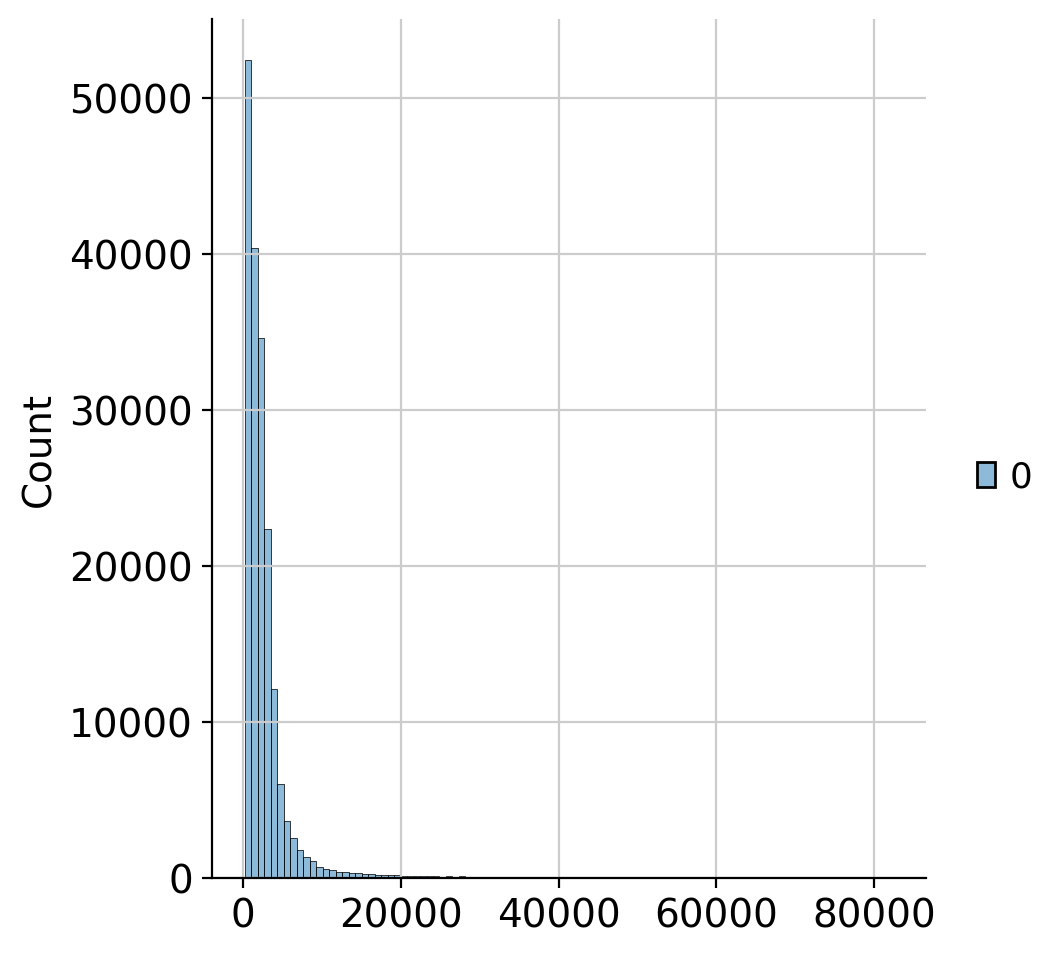

In [38]:
sns.displot(adata.X.sum(1), bins=100, kde=False)

### Quality Control

In [39]:
# Calculate mitochondrial / ribosomal / hemoglobin content

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

# calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

In [40]:
# Check max and min total counts
print('Minimum cell gene count:')
print(min(adata.obs['total_counts']))
print('Maximum cell gene count:')
print(max(adata.obs['total_counts']))

Minimum cell gene count:
213.0
Maximum cell gene count:
82497.8



Standard plots for counts:



/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


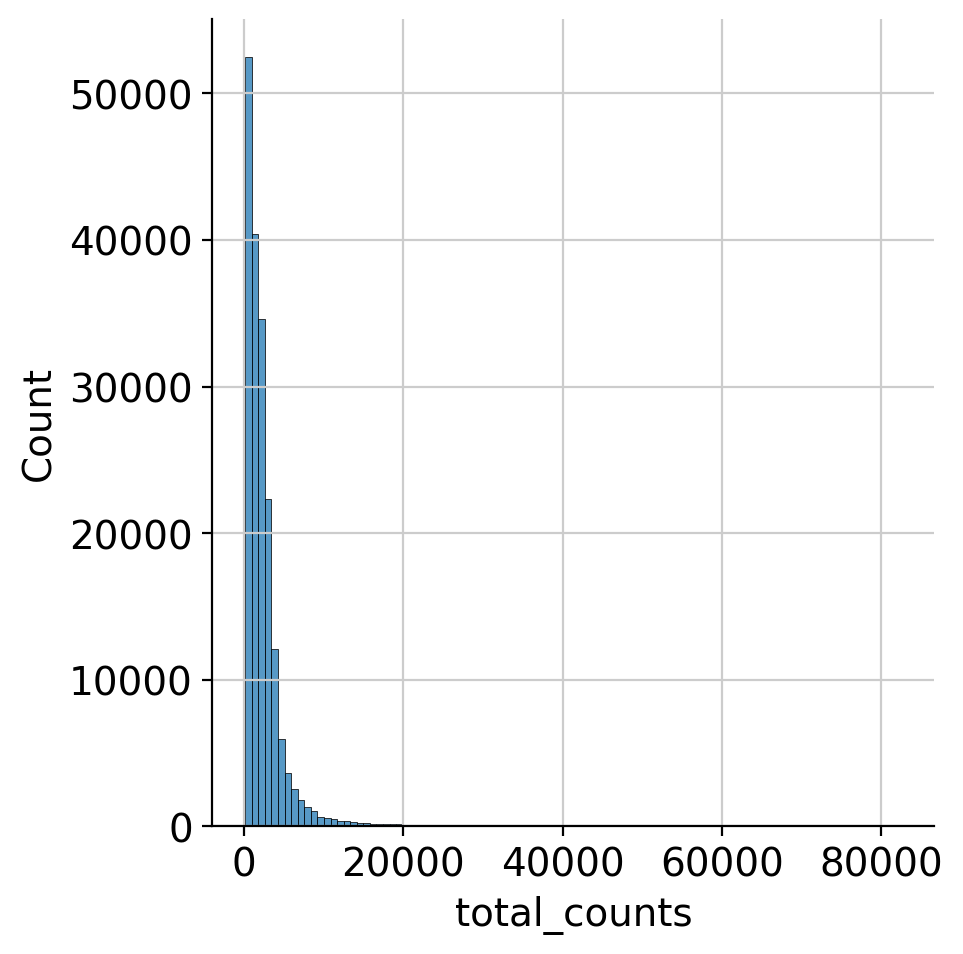

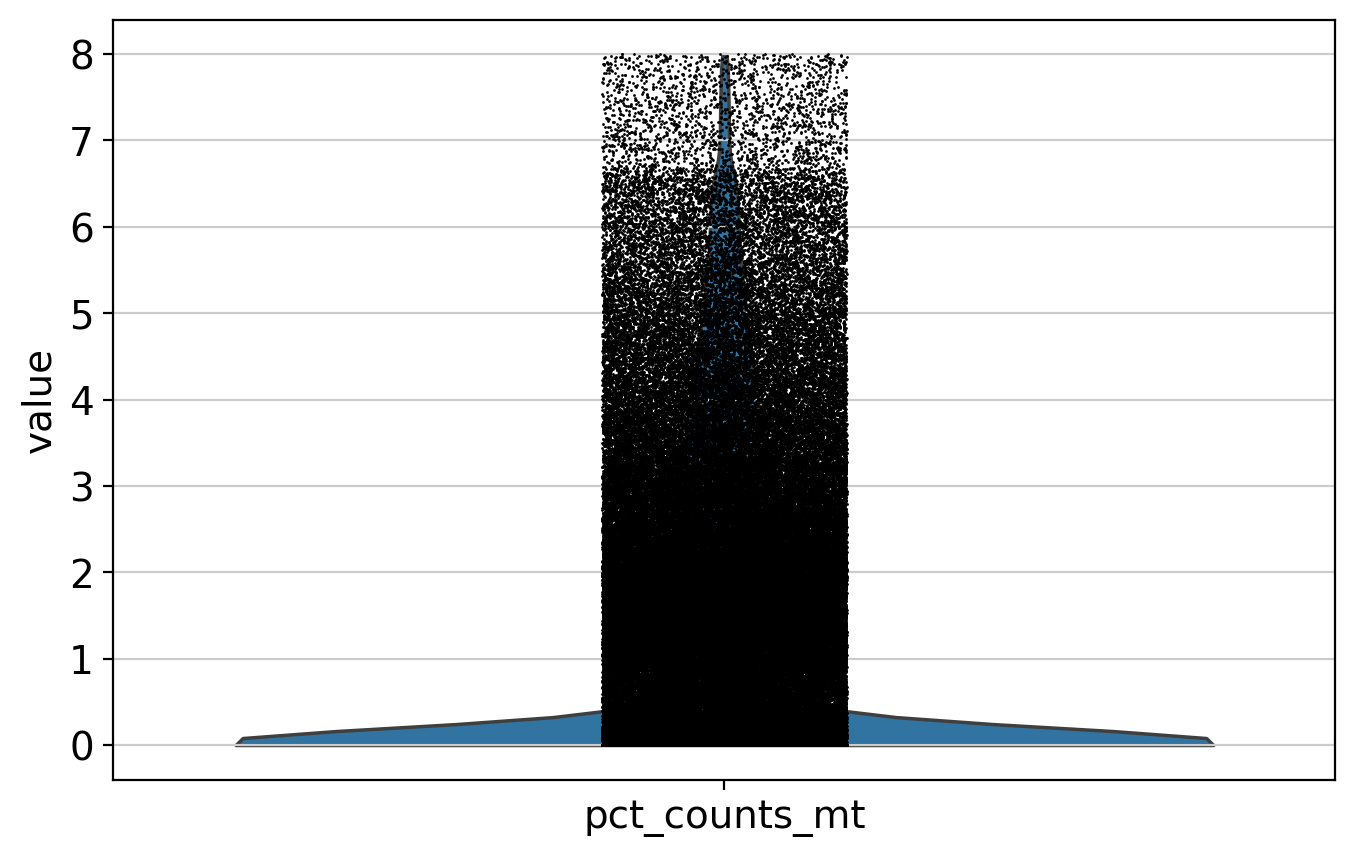

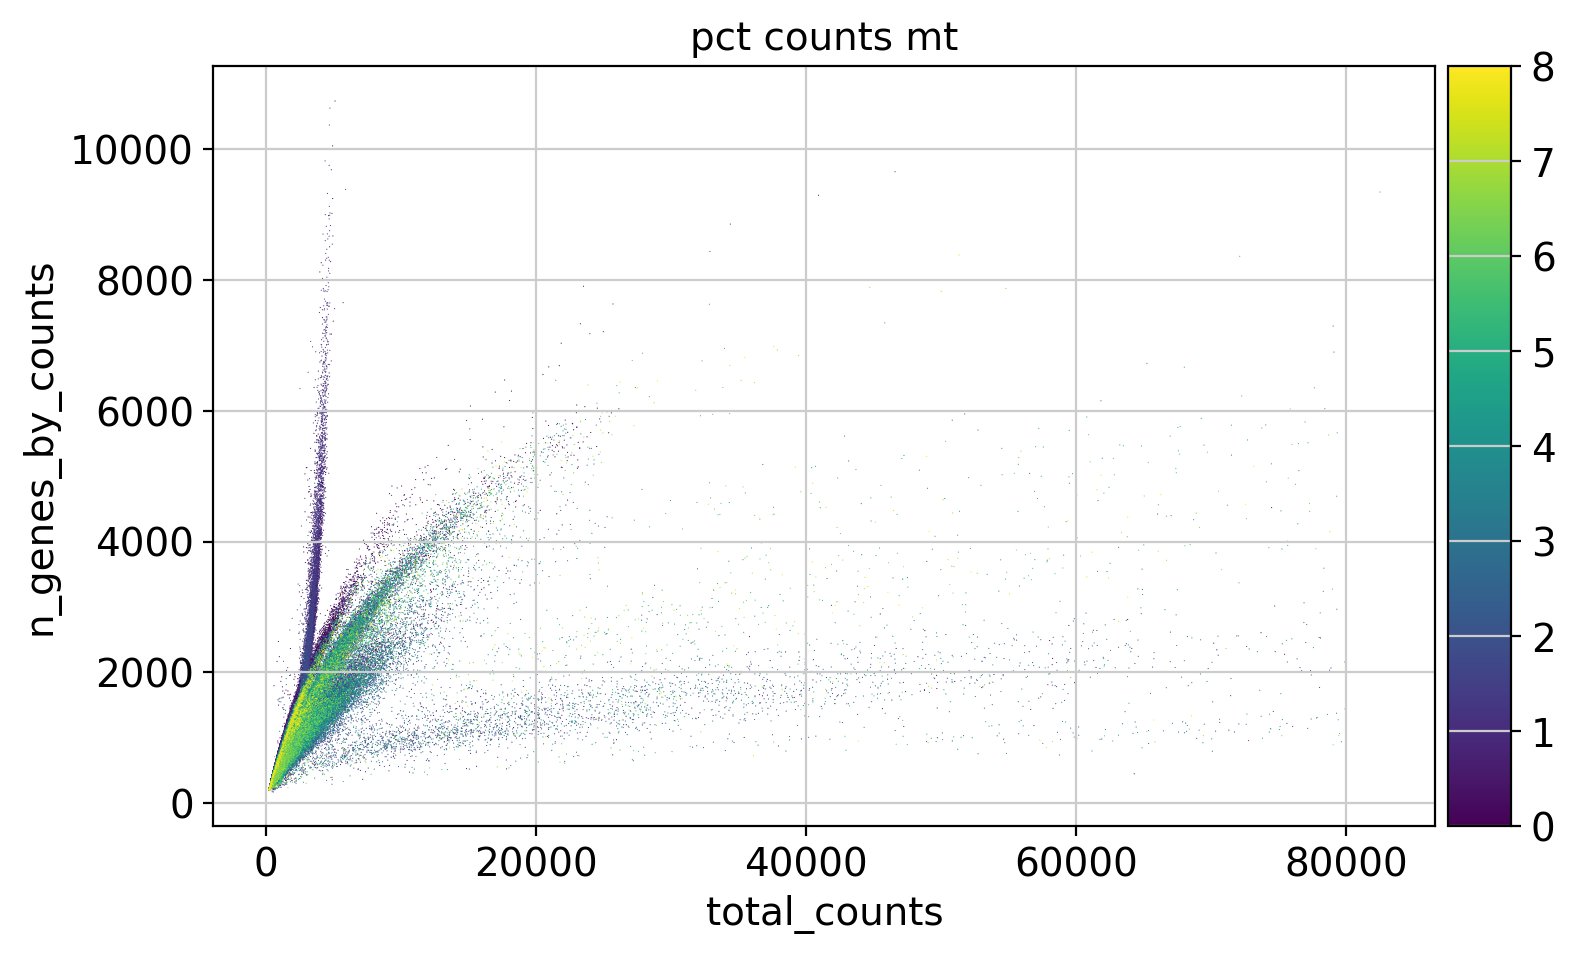

In [32]:
sc.settings.set_figure_params(dpi=100, figsize=(7,5), facecolor='white')


# Check standard plots 
print("\nStandard plots for counts:\n")
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_merged_PREprocessed.png")

/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


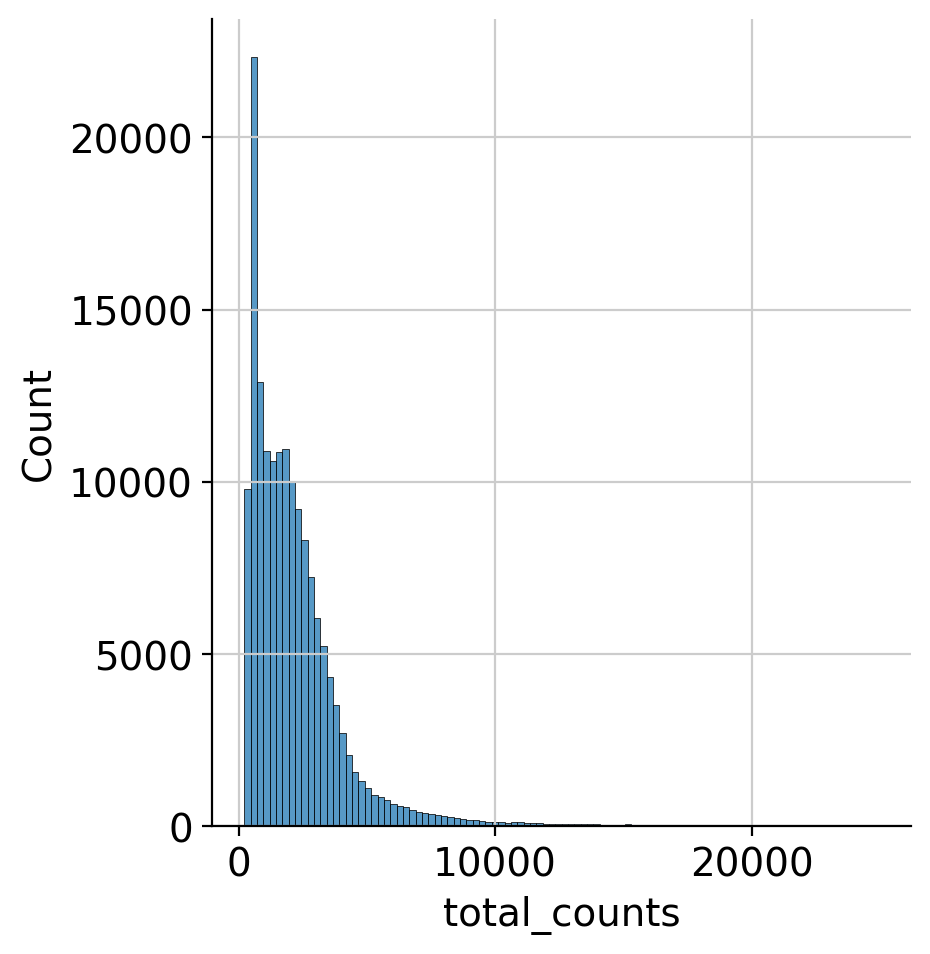

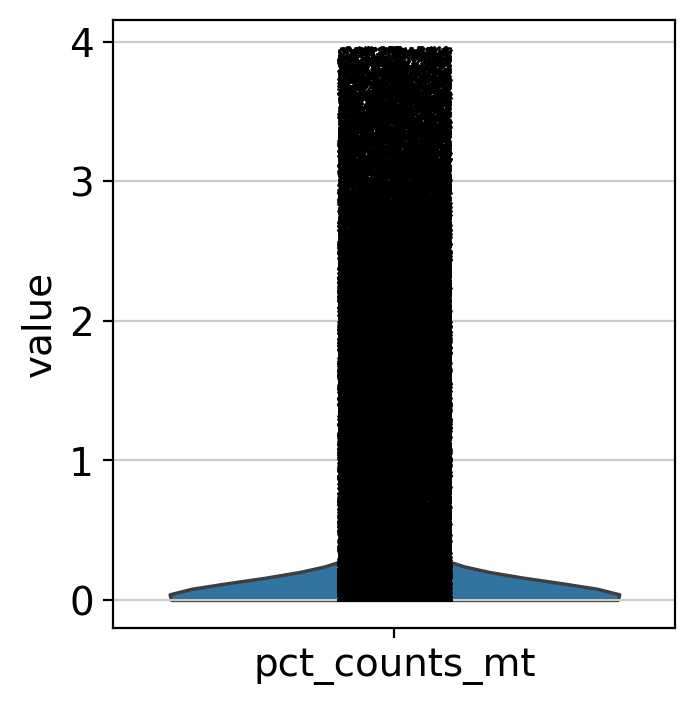

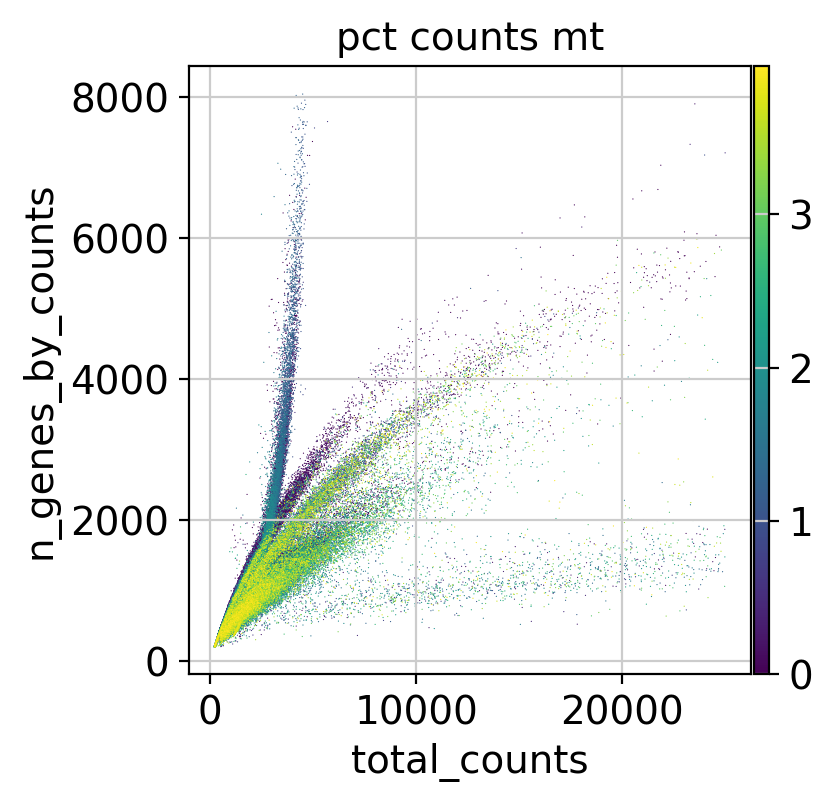

In [49]:
# Replotting on a subset of cells with a max gene counts of 100k
adata_subset = adata.obs[adata.obs["total_counts"] <= 25000]
p1 = sns.displot(adata_subset["total_counts"], bins=100, kde=False)


filtered_adata = adata[adata.obs["total_counts"] <= 25000].copy()
p2 = sc.pl.violin(filtered_adata, "pct_counts_mt")
p3 = sc.pl.scatter(filtered_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [41]:
# Filter cells based on 5 MADs (Mean Absolute Deviation)
    # MAD = median(|Xi - median(X)|), with Xi being value of respective QC metric 
    
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * scipy.stats.median_abs_deviation(M)) | (
        np.median(M) + nmads * scipy.stats.median_abs_deviation(M) < M
    )
    return outlier

# Apply function to get all cells exceeding a threshold of 5 MADs - these are outliers
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

# Remove filtering for MT - this was done independently on each dataset prior to merging
# adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
#     adata.obs["pct_counts_mt"] > 8
# )
# adata.obs.mt_outlier.value_counts()


False    183210
True       1456
Name: outlier, dtype: int64

In [42]:
# Actually filter and remove outliers
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 184666
Number of cells after filtering of low quality cells: 183210



After filtering cells and removing outliers:



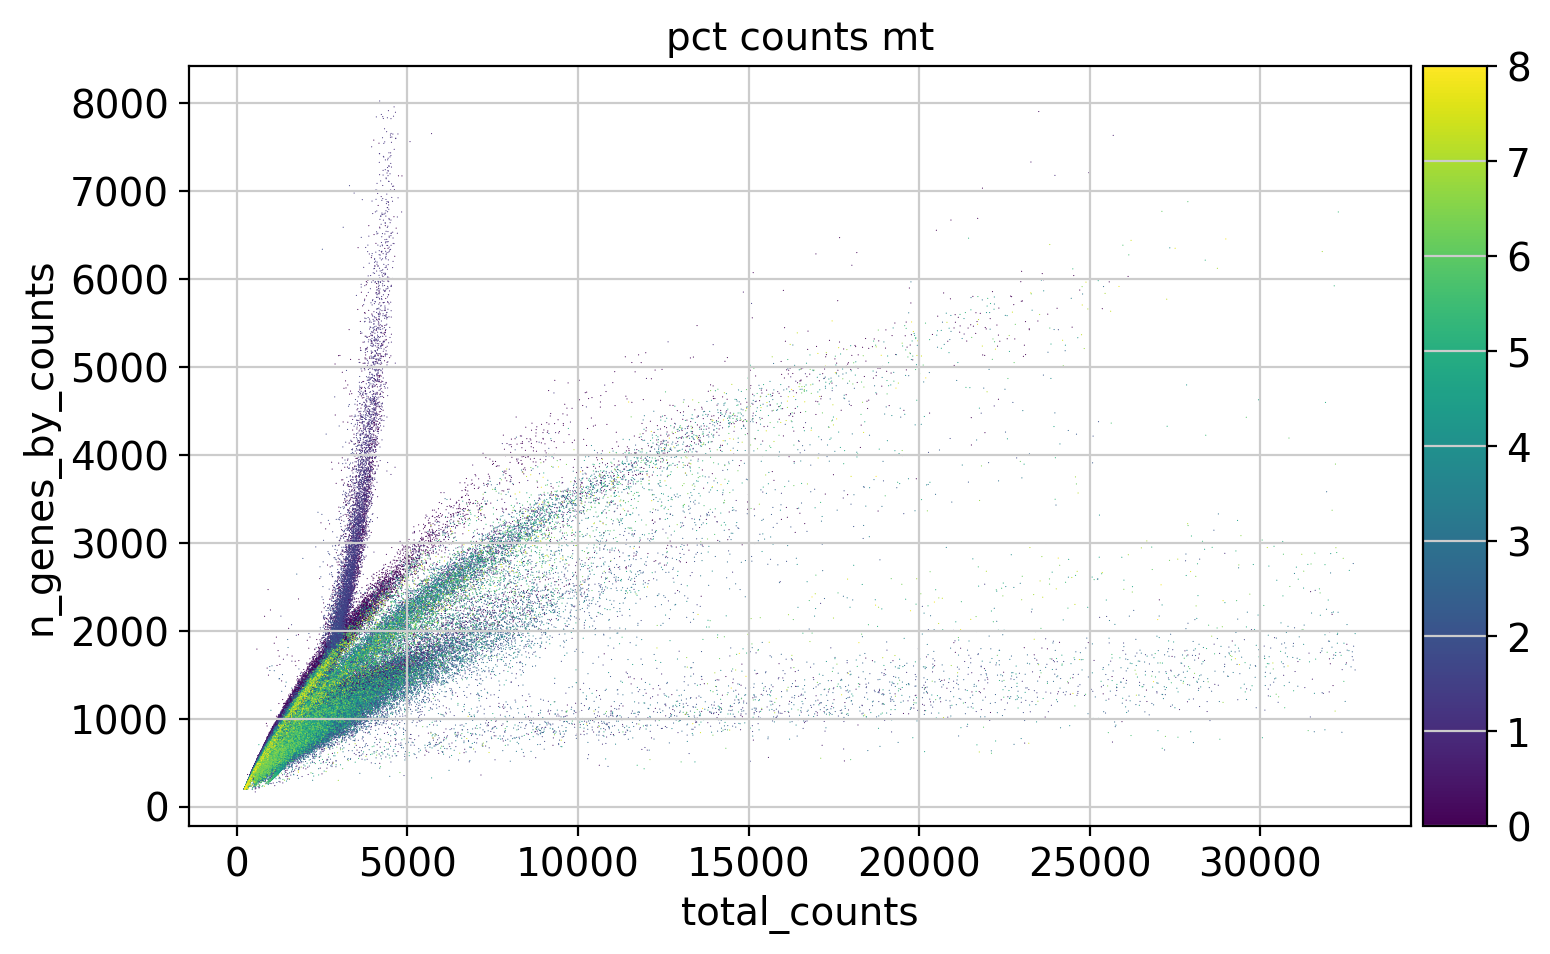

In [35]:
# Replot to check improvement of data quality
print("\nAfter filtering cells and removing outliers:\n")
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_merged_processed_NEW.png")

In [43]:
# Recheck min and max total counts
print('Minimum cell gene count:')
print(min(adata.obs['total_counts']))
print('Maximum cell gene count:')
print(max(adata.obs['total_counts']))

Minimum cell gene count:
213.0
Maximum cell gene count:
32785.0


In [22]:
print(adata.X[1:100, 1:100])

  (1, 43)	1.0
  (1, 31)	2.0
  (1, 28)	1.0
  (1, 30)	1.0
  (2, 90)	1.0
  (2, 11)	1.0
  (3, 6)	1.0
  (3, 11)	1.0
  (3, 30)	2.0
  (4, 11)	1.0
  (4, 98)	1.0
  (4, 14)	2.0
  (6, 90)	1.0
  (6, 91)	1.0
  (6, 27)	1.0
  (6, 80)	2.0
  (7, 44)	2.0
  (7, 29)	1.0
  (8, 31)	1.0
  (8, 30)	1.0
  (9, 52)	1.0
  (9, 10)	1.0
  (9, 31)	1.0
  (9, 84)	1.0
  (9, 30)	1.0
  :	:
  (88, 30)	2.0
  (88, 80)	1.0
  (89, 8)	1.0
  (89, 32)	1.0
  (89, 30)	2.0
  (90, 69)	1.0
  (90, 87)	2.0
  (90, 39)	1.0
  (92, 90)	1.0
  (92, 30)	1.0
  (93, 30)	1.0
  (94, 97)	1.0
  (94, 11)	1.0
  (94, 30)	1.0
  (95, 45)	1.0
  (95, 36)	1.0
  (95, 87)	1.0
  (95, 88)	1.0
  (96, 43)	1.0
  (96, 8)	1.0
  (97, 36)	1.0
  (97, 8)	1.0
  (97, 10)	1.0
  (97, 30)	1.0
  (98, 90)	1.0


In [46]:
################## Save a copy of .X into counts layers ################## 
adata.layers["raw_counts"] = adata.X

In [48]:
# write out raw counts file
adata.write('/project/data/gew123/Integration/Processed_Raw_Counts.h5ad')

In [23]:
adata

AnnData object with n_obs × n_vars = 183210 × 64612
    obs: 'Source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p'

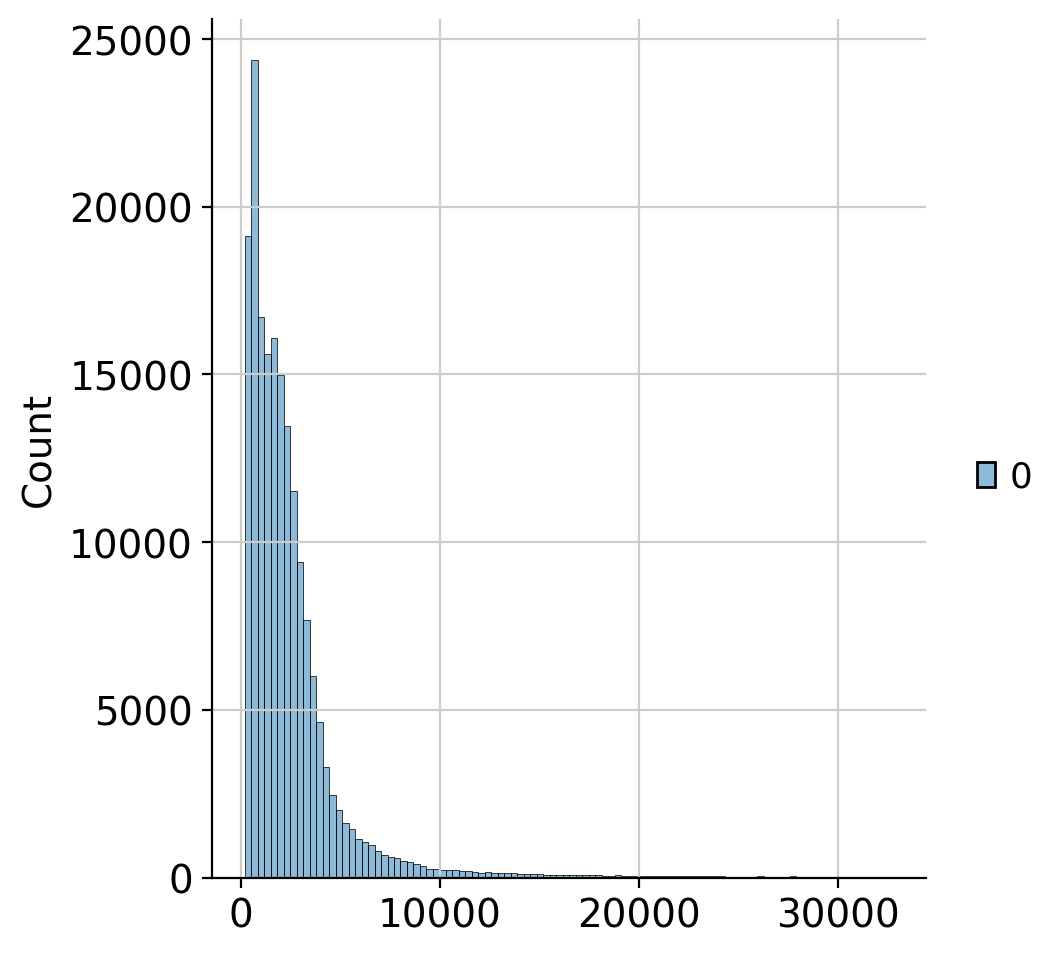

In [47]:
sns.displot(adata.X.sum(1), bins=100, kde=False)

### Normalization

In [21]:
# Normalize using shifted logarithm transformation
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)

# Save normalized counts
adata.layers['norm_counts'] = adata.X

# log1p transformed counts are added into a layer to preserve original counts
adata.layers["log_counts"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:18)



Inspect how counts changed after normalization:



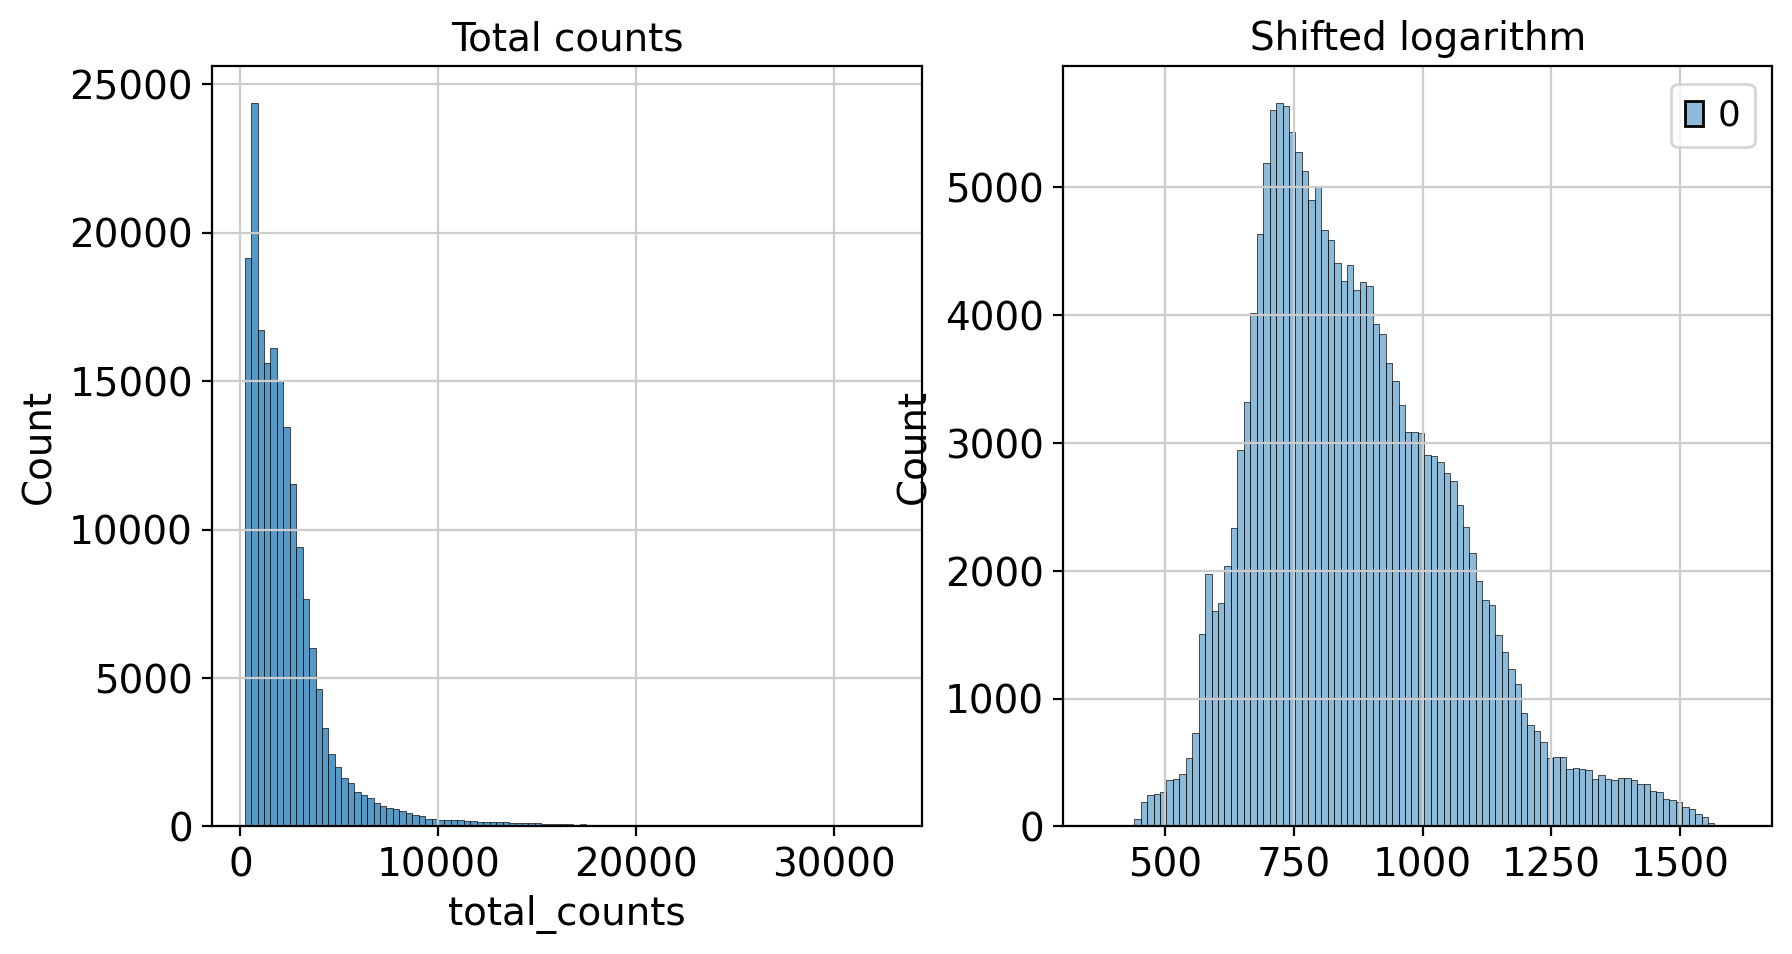

In [28]:
# Inspect how counts changed after normalization
print("\nInspect how counts changed after normalization:\n")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Unnormalised counts
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
#plt.savefig(f'{figures}/Merged_distribution_raw.png', bbox_inches='tight')

# Normalized counts
p2 = sns.histplot(adata.layers["log_counts"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
#plt.savefig(f'{figures}/Merged_distribution_logNorm.png', bbox_inches='tight')

plt.show()

In [22]:
# Check processed adata
print("\nProcessed adata:\n")
adata


Processed adata:



AnnData object with n_obs × n_vars = 183210 × 64612
    obs: 'Source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p', 'raw_counts', 'norm_counts', 'log_counts'

In [23]:
# Save merged object
adata.write(f'{merged_object}/Merged_Processed_NB.h5ad')

## NB + Control

In [55]:
# Get raw data
os.chdir('/project/data/nb24/Processed_h5ad')

# NB
jansky = sc.read_h5ad(f'{processed_data}/Jansky_processed.h5ad')
kildesiute = sc.read_h5ad(f'{processed_data}/Kildesiute_processed.h5ad')
slyper = sc.read_h5ad(f'{processed_data}/Slyper_processed.h5ad')
verhoeven = sc.read_h5ad(f'{processed_data}/Verhoeven_processed.h5ad')
wienke = sc.read_h5ad(f'{processed_data}/Wienke_processed.h5ad')
yuan = sc.read_h5ad(f'{processed_data}/Yuan_processed.h5ad')

# Controls
jansky_ctrl = sc.read_h5ad(f'{processed_data}/Jansky_CTRL_processed.h5ad')
kildesiute_ctrl = sc.read_h5ad(f'{processed_data}/Kildesiute_CTRL_processed.h5ad')
kameneva_ctrl = sc.read_h5ad(f'{processed_data}/Kameneva_CTRL_processed.h5ad')

In [56]:
# Label datasets

# NB
jansky.obs["Source"] = 'Jansky'
jansky.obs["Condition"] = 'NB'

kildesiute.obs["Source"] = 'Kildesiute'
kildesiute.obs["Condition"] = 'NB'

slyper.obs["Source"] = 'Slyper'
slyper.obs["Condition"] = 'NB'

verhoeven.obs["Source"] = 'Verhoeven'
verhoeven.obs["Condition"] = 'NB'

wienke.obs["Source"] = 'Wienke'
wienke.obs["Condition"] = 'NB'

yuan.obs["Source"] = 'Yuan'
yuan.obs["Condition"] = 'NB'


# Controls
jansky_ctrl.obs["Source"] = 'Jansky_CTRL'
jansky_ctrl.obs["Condition"] = 'Control'

kildesiute_ctrl.obs["Source"] = 'Kildesiute_CTRL'
kildesiute_ctrl.obs["condition"] = 'Control'

kameneva_ctrl.obs["Source"] = "Kameneva_CTRL"
kameneva_ctrl.obs["Condition"] = 'Control'

In [57]:
# Merge datasets
adata_list = [jansky, kildesiute, slyper, verhoeven, wienke, yuan, jansky_ctrl, kildesiute_ctrl, kameneva_ctrl]
adata = sc.concat(adata_list, join='outer')
# Make cell names unique
adata.obs_names_make_unique()

/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [59]:
# Get interested columns only
adata.obs = adata.obs[["source","condition"]]

In [60]:
# Clear variables
del jansky
del kildesiute
del slyper
del verhoeven
del wienke
del yuan
del kildesiute_ctrl
del jansky_ctrl
del kameneva_ctrl

In [61]:
# Check
print('Raw Merged dataset:')
adata

Raw Merged dataset:


AnnData object with n_obs × n_vars = 396840 × 64823
    obs: 'source', 'condition'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p'

In [62]:
# Save copy of raw merged adata
adata_merged_ctrl_raw = adata.copy()

### Quality Control

In [63]:
# Calculate mitochondrial / ribosomal / hemoglobin content

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

# calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scanpy/preprocessing/_qc.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[obs_metrics.columns] = obs_metrics
/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scanpy/preprocessing/_qc.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[obs_metrics.columns] = obs_metrics
/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11

In [64]:
# Check max and min total counts
print('Minimum cell gene count:')
print(min(adata.obs['total_counts']))
print('Maximum cell gene count:')
print(max(adata.obs['total_counts']))

Minimum cell gene count:
208.0
Maximum cell gene count:
316798.0



Standard plots for counts:



/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/anndata/_core/anndata.py:1292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/anndata/_core/anndata.py:1292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `

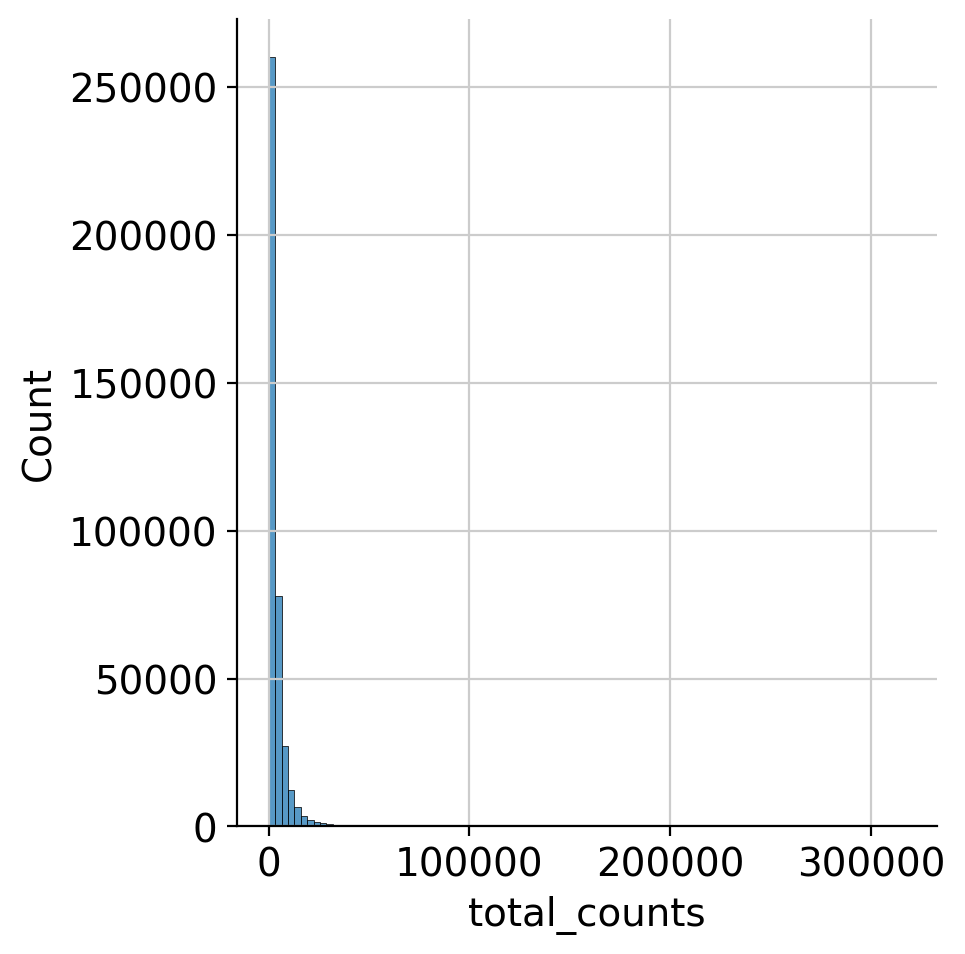

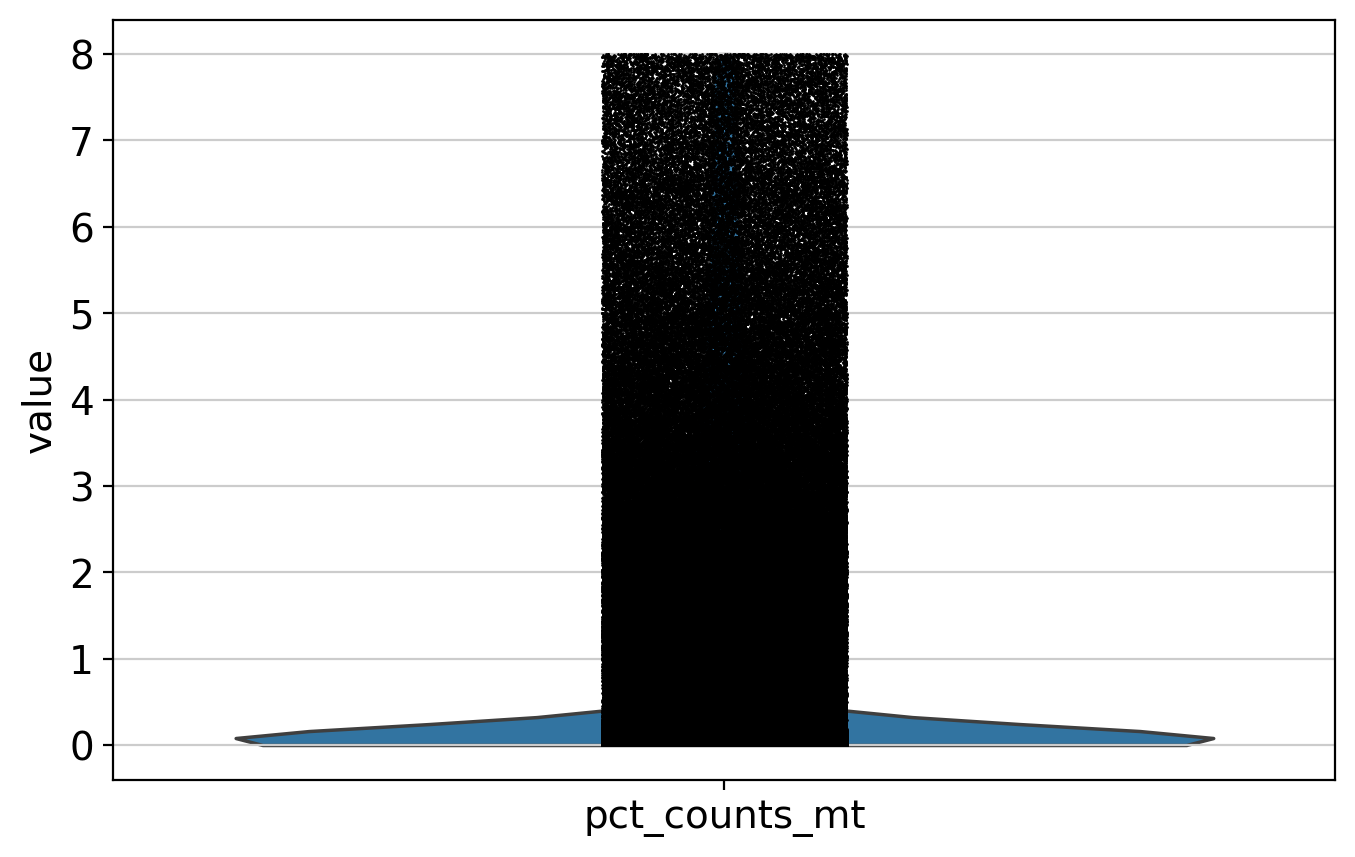

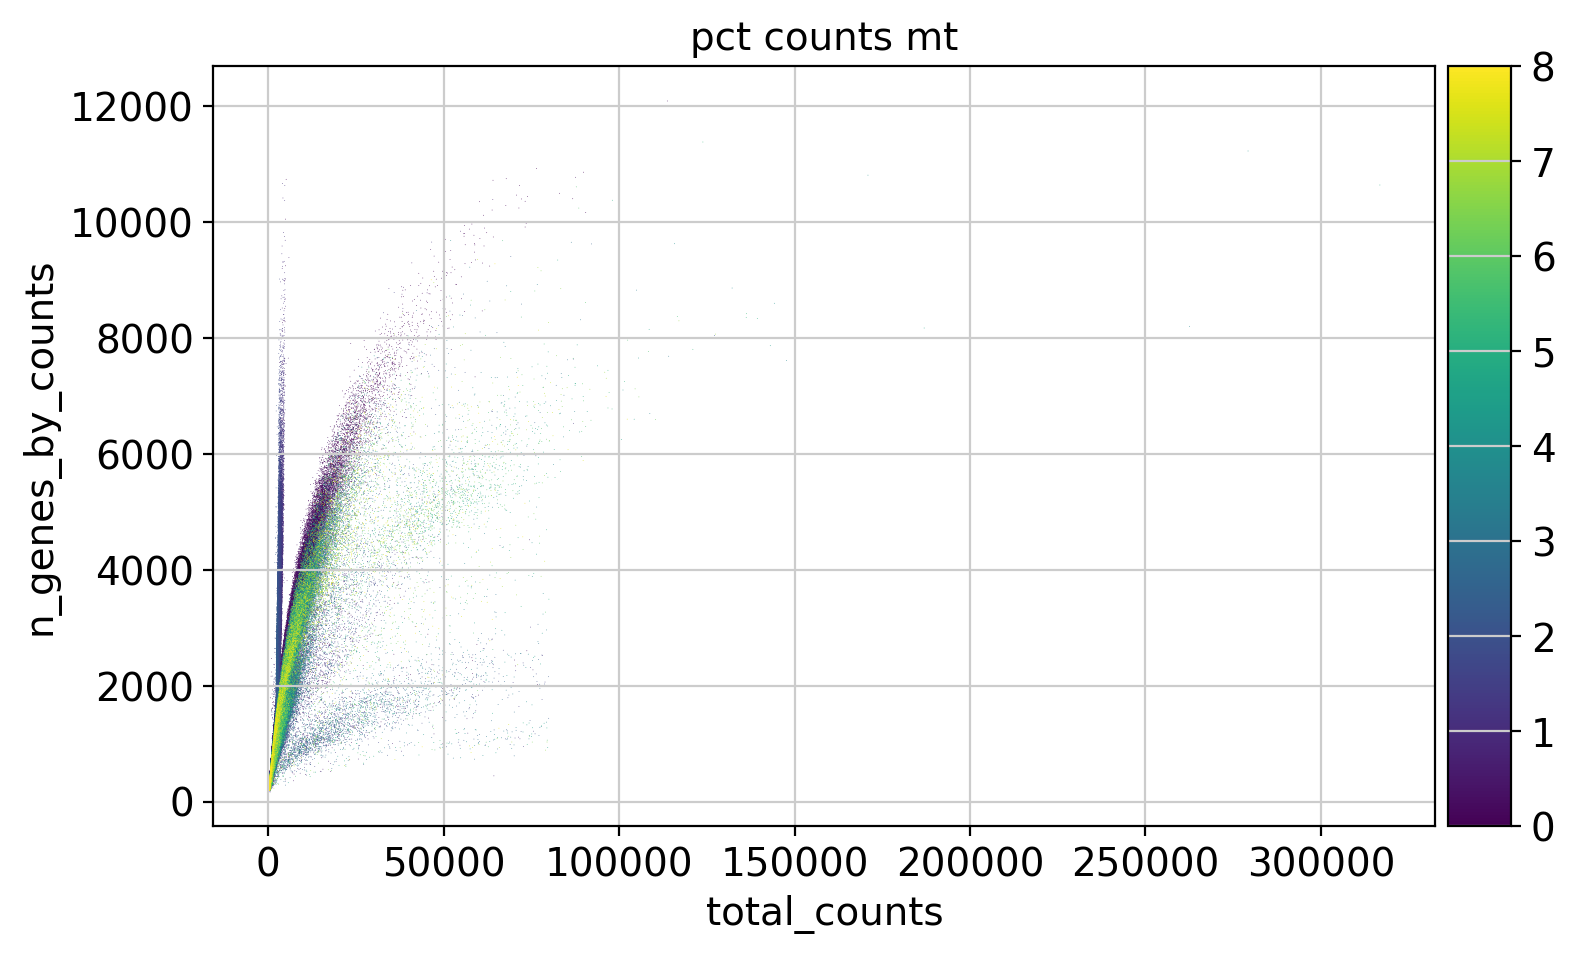

In [65]:
sc.settings.set_figure_params(dpi=100, figsize=(7,5), facecolor='white')


# Check standard plots 
print("\nStandard plots for counts:\n")
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_merged_CTRL_PREprocessed.png")

In [67]:
# Filter cells based on 5 MADs (Mean Absolute Deviation)
    # MAD = median(|Xi - median(X)|), with Xi being value of respective QC metric 
    
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * scipy.stats.median_abs_deviation(M)) | (
        np.median(M) + nmads * scipy.stats.median_abs_deviation(M) < M
    )
    return outlier

# Apply function to get all cells exceeding a threshold of 5 MADs - these are outliers
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

# Remove filtering for MT - this was done independently on each dataset prior to merging
# adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
#     adata.obs["pct_counts_mt"] > 8
# )
# adata.obs.mt_outlier.value_counts()

/tmp/ipykernel_99196/2096546551.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["outlier"] = (


False    391033
True       5807
Name: outlier, dtype: int64

In [68]:
# Actually filter and remove outliers
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 396840
Number of cells after filtering of low quality cells: 391033



After filtering cells and removing outliers:



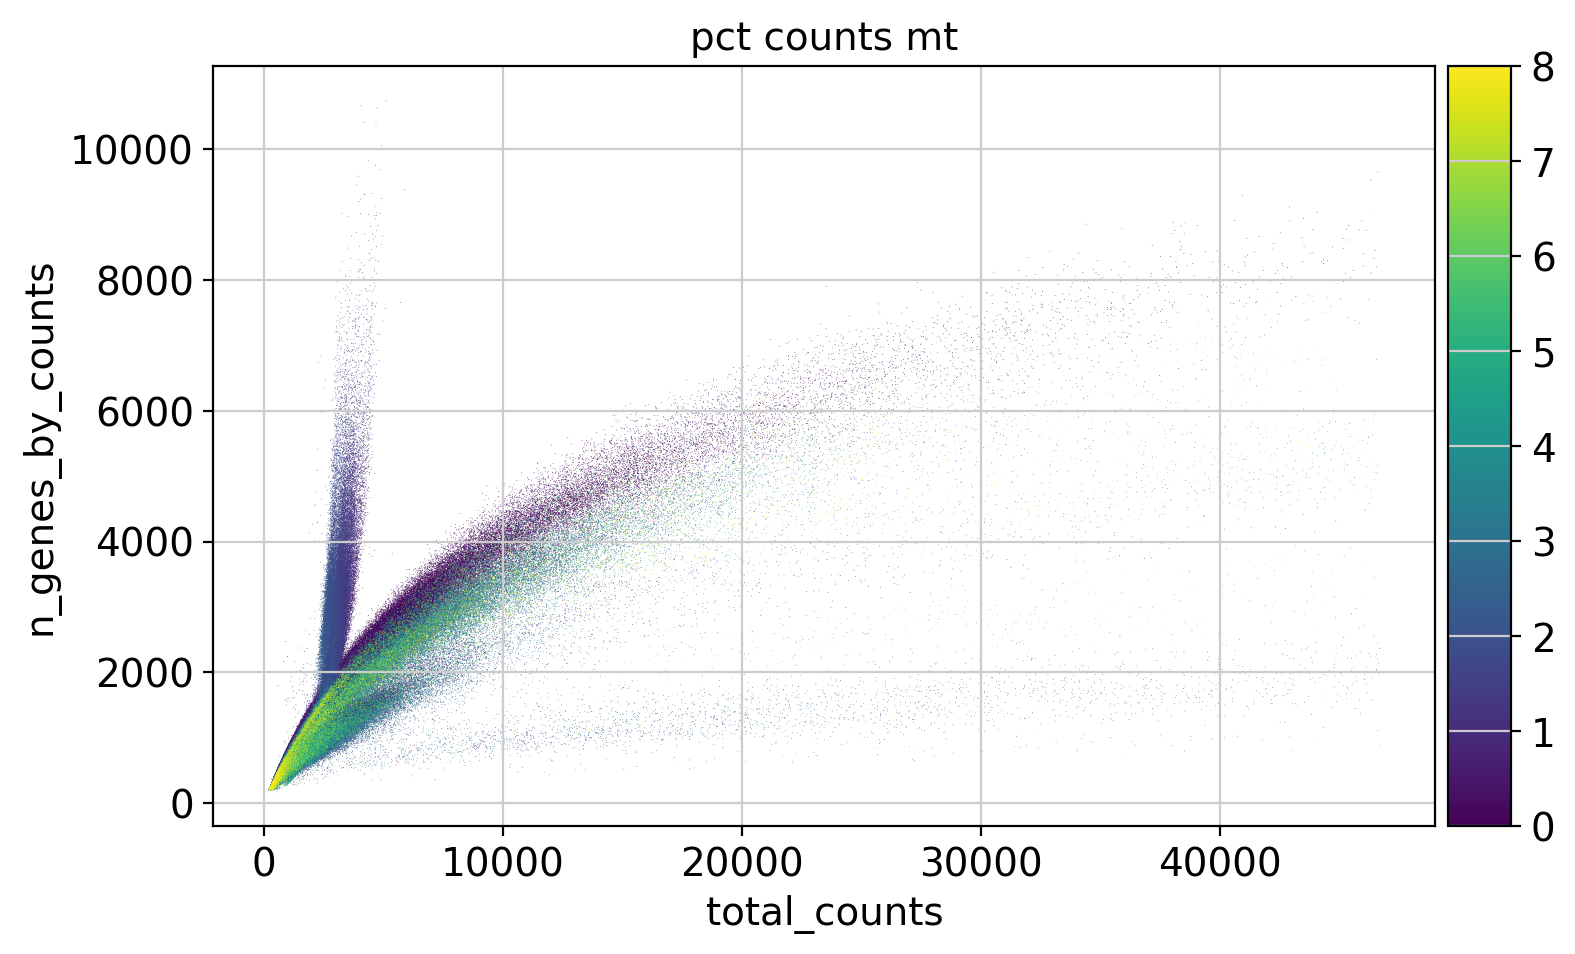

In [69]:
# Replot to check improvement of data quality
print("\nAfter filtering cells and removing outliers:\n")
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_merged_CTRL_processed.png")

In [70]:
# Recheck min and max total counts
print('Minimum cell gene count:')
print(min(adata.obs['total_counts']))
print('Maximum cell gene count:')
print(max(adata.obs['total_counts']))

Minimum cell gene count:
208.0
Maximum cell gene count:
46673.0


In [71]:
adata.X

<391033x64823 sparse matrix of type '<class 'numpy.float64'>'
	with 704453481 stored elements in Compressed Sparse Row format>

In [72]:
################## Save a copy of .X into counts layers ################## 
adata.layers["counts"] = adata.X

### Normalization

In [73]:
# Normalize using shifted logarithm transformation
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)

# log1p transformed counts are added into a layer to preserve original counts
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:18)



Inspect how counts changed after normalization:



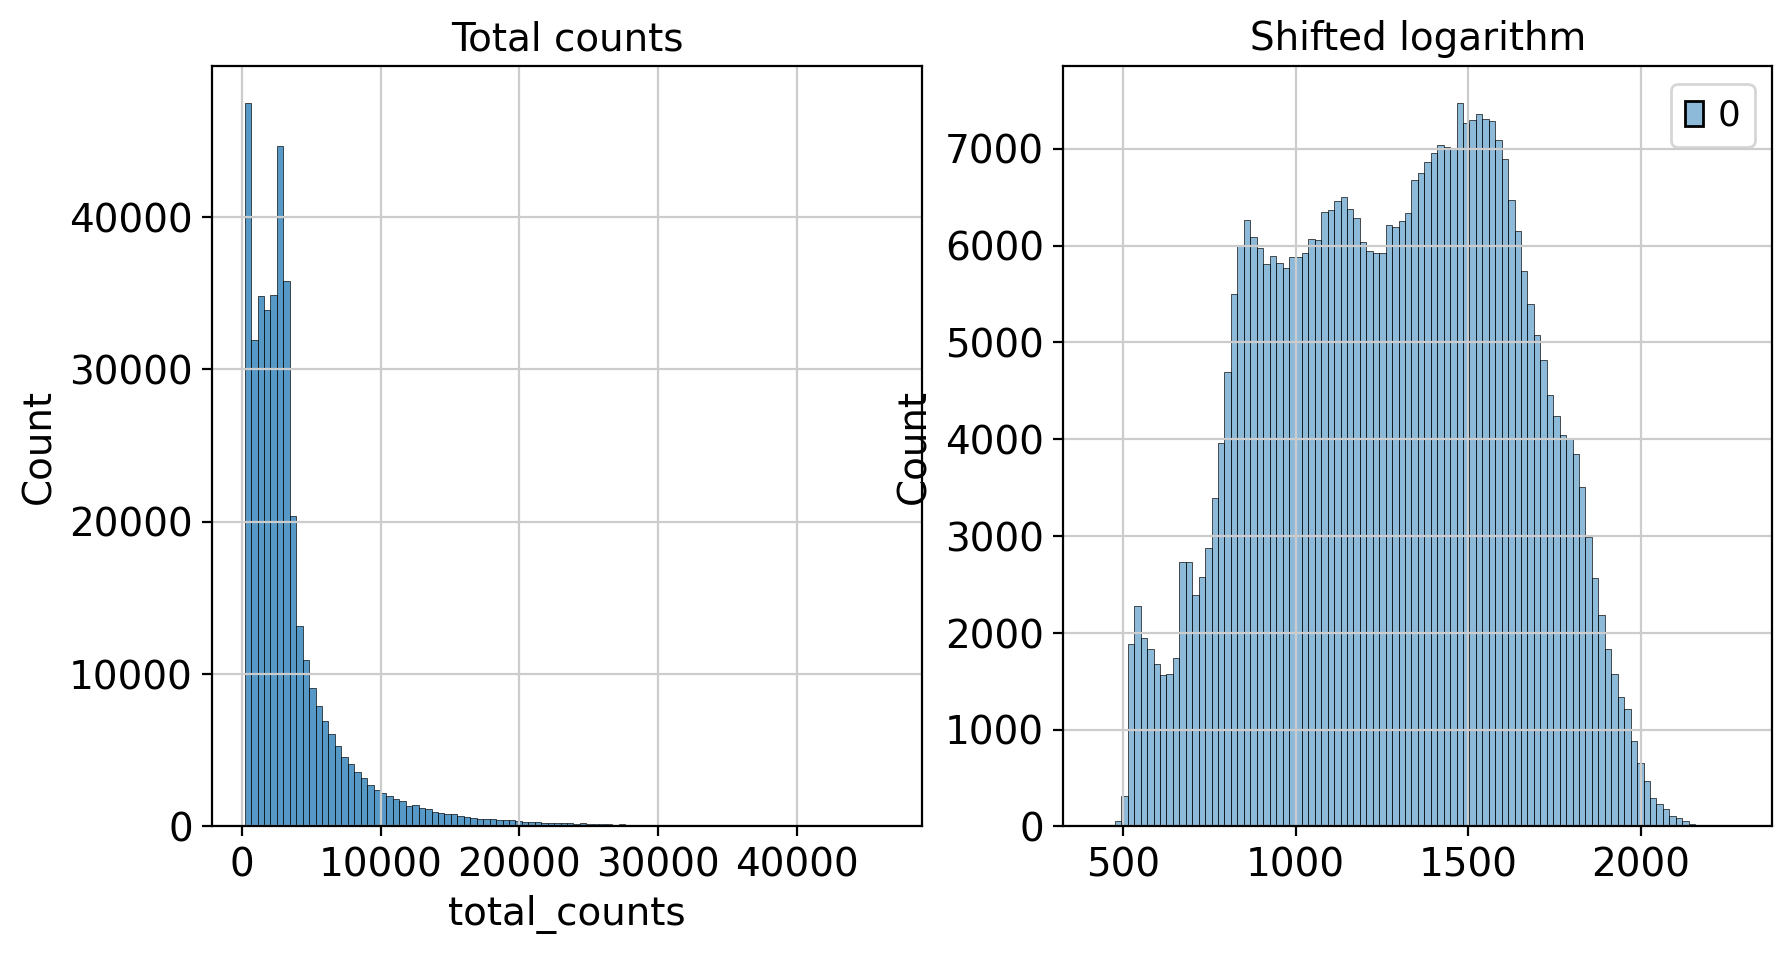

In [74]:
# Inspect how counts changed after normalization
print("\nInspect how counts changed after normalization:\n")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Unnormalised counts
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
plt.savefig(f'{figures}/Merged_distribution_CTRL_raw.png', bbox_inches='tight')

# Normalized counts
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.savefig(f'{figures}/Merged_distribution_CTRL_logNorm.png', bbox_inches='tight')

plt.show()

In [76]:
# Check processed adata
print("\nProcessed adata:\n")
adata


Processed adata:



AnnData object with n_obs × n_vars = 391033 × 64823
    obs: 'source', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p', 'counts', 'log1p_norm'

In [75]:
# Save merged object
adata.write(f'{merged_object}/Merged_Processed_CTRL.h5ad')